In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create and shuffle database
words = open("names.txt").read().splitlines()
random.seed(42)
random.shuffle(words)

In [3]:
# Split database
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)
train_db = words[:n1]
dev_db = words[n1:n2]
test_db = words[n2:]

In [4]:
V = ['.'] + sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(V)}
itos = {i:s for s, i in stoi.items()}
print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [5]:
# Smoothed n-gram model
p_0 = 1/len(V) # uniform freq

# unigram
word_freq = [0]*27
n_letters = 0
for word in train_db:
    for ch in word + '.':
        ix = stoi[ch]
        word_freq[ix] += 1
        n_letters += 1
p_1 = torch.tensor([i/n_letters for i in word_freq])

In [6]:
# bigram
M_2 = torch.zeros((27, 27))
for word in train_db:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        M_2[ix1, ix2] += 1

In [7]:
M_2 = (M_2+1)
p_2 = (M_2 / M_2.sum(1, keepdims=True)).float()

In [8]:
# trigram
M_3 = torch.zeros((27, 27, 27), dtype=torch.int32)
for word in train_db:
    chs = ['.'] + ['.'] + list(word) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        M_3[ix1, ix2, ix3] += 1

In [9]:
M_3 = (M_3+1)
p_3 = (M_3 / M_3.sum(2, keepdims=True)).float()

In [10]:
# word freq
pm = []
for word in dev_db:
    chs = ['.'] + ['.'] + list(word) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        pm.append([p_0, p_1[ix3].item(), p_2[ix2, ix1].item(), p_3[ix1, ix2, ix3].item()]) 

In [11]:
prob_matrix = torch.tensor(pm)

In [12]:
# EM algorithm
weights = torch.ones(4) / 4
for i in range(5):
    # E-step
    weighted_probs = prob_matrix * weights
    total_probs = weighted_probs.sum(1, keepdims=True)
    z = weighted_probs / total_probs
    
    # M-step
    weights = z.mean(0)

In [13]:
weights

tensor([0.0146, 0.0762, 0.0933, 0.8158])

In [14]:
# Hyperparameters
block_size = 2
embedding_size = 20
hidden_layer_size = 200
epochs = 100000
minibatch_size = 64
learning_rate = 0.01
lr_decay_factor = 10

In [15]:
def create_db(words):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y
X_train, y_train = create_db(train_db)
X_dev, y_dev = create_db(dev_db)
X_test, y_test = create_db(test_db)

In [16]:
def get_ngram_probs(X):
    P = []
    for ex in X:
        p = weights[0]*p_0 + weights[1]*p_1[torch.arange(27)] + weights[2]*p_2[ex[1], :] + weights[3]*p_3[ex[0], ex[1], :]
        P.append(p)
    probs = torch.stack(P, dim=0)
    return probs

In [17]:
# Create MLP

In [18]:
# Initialize weights
g = torch.Generator().manual_seed(2147483647)
E = torch.randn((27, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_layer_size), generator=g) * (5/3)/((block_size * embedding_size)**0.5)
#b1 = torch.randn(hidden_layer_size, generator=g) * 0.01
W2 = torch.randn((hidden_layer_size, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

bngain = torch.ones((1, hidden_layer_size))
bnbias = torch.zeros((1, hidden_layer_size))
bnmean_running = torch.zeros((1, hidden_layer_size))
bnstd_running = torch.ones((1, hidden_layer_size))

parameters = [E, W1, W2, b2, bngain, bnbias]

In [19]:
# Require grad
for p in parameters:
    p.requires_grad = True

Epoch: 0/100000: 3.2758
Epoch: 10000/100000: 2.5977
Epoch: 20000/100000: 2.2292
Epoch: 30000/100000: 2.3636
Epoch: 40000/100000: 2.4417
Epoch: 50000/100000: 2.2758
Epoch: 60000/100000: 2.0797
Epoch: 70000/100000: 2.2117
Epoch: 80000/100000: 2.1958
Epoch: 90000/100000: 2.3192


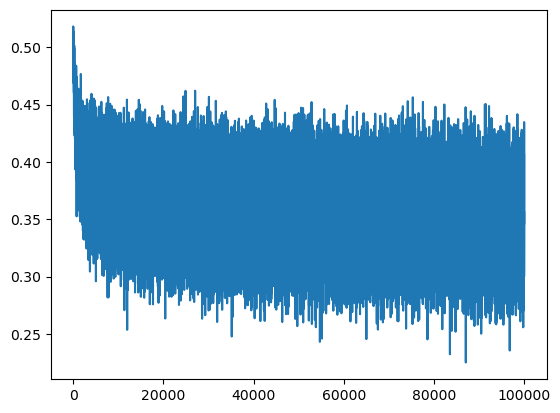

In [20]:
# Gradient descent
lossi = []
stepi = []
for i in range(epochs):
    # construct minibatch
    ix = torch.randint(0, X_train.shape[0], (minibatch_size,), generator=g)
    Xb, yb = X_train[ix], y_train[ix]

    # forward pass
    emb = E[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias #batchnorm
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        lr = learning_rate
        if i > int(0.9*epochs):
            lr /= lr_decay_factor
        p.data += -learning_rate * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())
    if i%10000 == 0:
        print(f'Epoch: {i}/{epochs}: {loss.item():.4f}')
plt.plot(stepi, lossi);

In [32]:
@torch.no_grad()
def split_mlp_loss(split):
    x, y = {
        'train': (X_train, y_train),
        'dev': (X_dev, y_dev),
        'test': (X_test, y_test)
    }[split]
    emb = E[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias #batchnorm
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_mlp_loss('train')
split_mlp_loss('dev')

train 2.2381343841552734
dev 2.248711585998535


In [34]:
ngram_logits = torch.log(get_ngram_probs(X_test))

In [35]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, y_train),
        'dev': (X_dev, y_dev),
        'test': (X_test, y_test)
    }[split]
    emb = E[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias #batchnorm
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy((logits + ngram_logits)/2, y)
    print(split, loss.item())

split_loss('test')

test 2.238787889480591


In [38]:
for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        emb = E[torch.tensor([context])]
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ngram_probs = get_ngram_probs(torch.tensor([context]))
        ix = torch.multinomial((probs + ngram_probs)/2, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

akycesvhil.
hutt.
gonnahs.
brniari.
belie.
